In [31]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [32]:
import numpy as np

In [33]:
import tensorflow as tf

In [34]:
from tensorflow.keras import models,layers

In [35]:
import matplotlib.pyplot as plt

In [ ]:
image_size = 128
batch_size =32
epochs =120

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "trains",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True
)

Found 15229 files belonging to 41 classes.


In [39]:
class_names = dataset.class_names
class_names

['American Bollworm on Cotton',
 'Anthracnose on Cotton',
 'Army worm',
 'Becterial Blight in Rice',
 'Brownspot',
 'Common_Rust',
 'Cotton Aphid',
 'Flag Smut',
 'Gray_Leaf_Spot',
 'Healthy Maize',
 'Healthy Wheat',
 'Healthy cotton',
 'Leaf Curl',
 'Leaf smut',
 'Mosaic sugarcane',
 'RedRot sugarcane',
 'RedRust sugarcane',
 'Rice Blast',
 'Sugarcane Healthy',
 'Tungro',
 'Wheat Brown leaf Rust',
 'Wheat Stem fly',
 'Wheat aphid',
 'Wheat black rust',
 'Wheat leaf blight',
 'Wheat mite',
 'Wheat powdery mildew',
 'Wheat scab',
 'Wheat___Yellow_Rust',
 'Wilt',
 'Yellow Rust Sugarcane',
 'bacterial_blight in Cotton',
 'bollworm on Cotton',
 'cotton mealy bug',
 'cotton whitefly',
 'maize ear rot',
 'maize fall armyworm',
 'maize stem borer',
 'pink bollworm in cotton',
 'red cotton bug',
 'thirps on  cotton']

In [40]:
len(dataset)

476

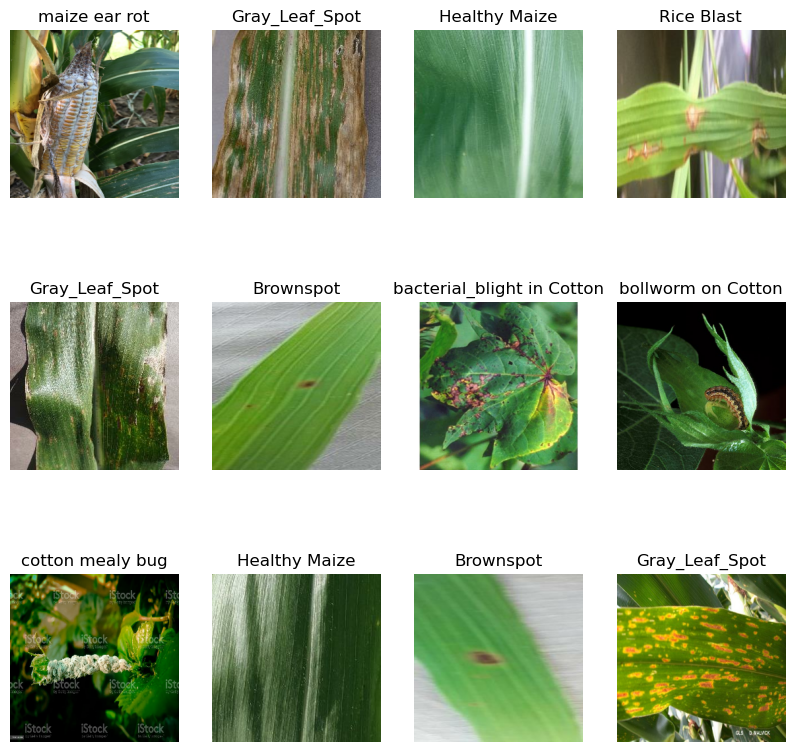

In [41]:
plt.figure(figsize=(10,10))
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")

In [42]:
len(dataset)

476

In [43]:
#80% => train
#20% => 10% - test , 10% - validate

In [44]:
def dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size = int(ds_size*train_split)
    valid_size = int(ds_size*valid_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(valid_size)
    valid_ds = ds.skip(train_size).skip(valid_size)
    return train_ds,test_ds,valid_ds

In [45]:
train_ds,test_ds,valid_ds = dataset_partitions_tf(dataset)

In [46]:
len(train_ds)

380

In [47]:
len(test_ds)

47

In [48]:
len(valid_ds)

49

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [50]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [51]:
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [52]:
# Resize and rescale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255)
])

In [53]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [54]:
n_classes = len(class_names)

In [55]:
# CNN model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])


In [56]:
# Build model (correct input shape)
model.build(input_shape=(None, image_size, image_size, 3))

In [57]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,450,345 (32.24 MB)

 Trainable params: 8,450,345 (32.24 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Compile
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",        # watch validation loss
        patience=10,               # stop if no improvement for 10 epochs
        restore_best_weights=True  # keep best weights
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",        # watch validation loss
        factor=0.2,                # reduce LR by 0.2
        patience=5,                # wait 5 epochs before reducing
        min_lr=1e-6                # don’t let LR go below this
    )
]

In [60]:
# Train
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_ds,
    verbose=1,
    callbacks=callbacks  
)

Epoch 1/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.4209 - loss: 2.1725 - val_accuracy: 0.5344 - val_loss: 1.7057 - learning_rate: 0.0010
Epoch 2/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.6063 - loss: 1.4661 - val_accuracy: 0.6454 - val_loss: 1.2816 - learning_rate: 0.0010
Epoch 3/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.6642 - loss: 1.2187 - val_accuracy: 0.6556 - val_loss: 1.2358 - learning_rate: 0.0010
Epoch 4/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.7096 - loss: 1.0610 - val_accuracy: 0.7385 - val_loss: 0.9605 - learning_rate: 0.0010
Epoch 5/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - accuracy: 0.7464 - loss: 0.9300 - val_accuracy: 0.7672 - val_loss: 0.8936 - learning_rate: 0.0010
Epoch 6/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.7630 - loss: 0.8556 - val_accuracy: 0.7978 - val_loss: 0.7164 - learning_rate: 0.0010
Epoch 7/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - accuracy: 0.7919 - l

In [61]:
scores = model.evaluate(test_ds)

47/47 ━━━━━━━━━━━━━━━━━━━━ 117s 553ms/step - accuracy: 0.9548 - loss: 0.1568


In [ ]:
import os
from tensorflow import keras

# Version number
model_version = 1

# Define folder path
save_dir = "./saved_models"

# Create folder if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)

# Define full save path (e.g., ./saved_models/1.keras)
model_path = os.path.join(save_dir, f"{model_version}.keras")

# Save the entire model
model.save(model_path)

print(f"Model saved at: {model_path}")

INFO:tensorflow:Assets written to: ../newmodels/4.h5\assets


INFO:tensorflow:Assets written to: ../newmodels/4.h5\assets


Saved artifact at '../newmodels/4.h5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 41), dtype=tf.float32, name=None)
Captures:
  3049835008208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049835009936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049835009744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049835010320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049864835536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049834792528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049834792336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049834794064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049834793872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049834796752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3049834796560: TensorSpec(sha